## Importing Packages

In [92]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [94]:
device

device(type='cuda')

## Loading Fashion-MNIST

In [95]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False,transform=transforms.ToTensor())

In [96]:
len(test_dataset)

10000

In [97]:
train_size = int(len(train_dataset) * 0.9) # 80% training data
valid_size = len(train_dataset) - train_size # 20% validation data
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [98]:
len(valid_dataset)

6000

## Setting the hyperparameters

In [175]:
input_size = 28*28*1 # as the image is of size 28X28X1, 1 - grey scale, and input will have 28*28 sized input array
batch_size = 200
num_of_labels = 10
epochs = 5
learning_rate = 0.001

## Creating the iterables

In [176]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

In [177]:
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=True)

In [178]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [179]:
#to check the values
value = iter(val_loader)
value_data, value_label = next(value)
print(value_data.shape, value_label.shape)

torch.Size([200, 1, 28, 28]) torch.Size([200])


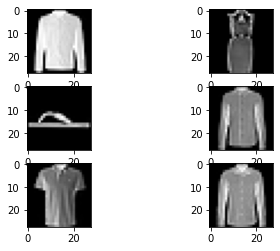

In [180]:
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(value_data[i][0], cmap='gray')
plt.show()

## Definig the Neural Networks

In [181]:
from torch.nn.modules import Tanh
class LeNet5(nn.Module):

  def __init__(self, input_size, no_of_labels):
    super(LeNet5, self).__init__()
    # self.linear1 = nn.Linear(input_size, hidden_size)
    # self.Relu = nn.ReLU()
    # self.linear2 = nn.Linear(hidden_size, no_of_labels)
    self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(6), # this is to increase network and for the same batch size and epoch value, it gives a good result
            nn.ReLU(), #should have been tanh but relu gives better as per recent discoveries.
            nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0, ceil_mode = False)
        )
    self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.BatchNorm2d(16), # this is to increase network and for the same batch size and epoch value, it gives a good result
            nn.ReLU(), #should have been tanh but relu gives better as per recent discoveries.
            nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0, ceil_mode = False)
        )
    self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(), #should have been tanh but relu gives better as per recent discoveries.
            nn.Flatten(start_dim=1)
        )
    # not using any activation function, as we are using Cross-entropy as our loss calculation
    self.fc = nn.Sequential(
        nn.Linear(in_features = 120,out_features = 84),
        nn.ReLU(), #should have been tanh but relu gives better as per recent discoveries.
        nn.Linear(in_features = 84,out_features = 10)
    )

  def forward(self, X):
    # out = self.layer1(X)
    # out = self.layer2(out)
    # out = out.view(out.size(0), -1)
    # out = self.fc(out)
    out = self.layer1(X)
    out = self.layer2(out)
    out = self.layer3(out)
    # #out = out.view(out.size(0), -1)
    # out = out.flatten(out, 1)
    out = self.fc(out)
    return out

In [182]:
model = LeNet5(input_size=input_size, no_of_labels = num_of_labels).to(device)

In [183]:
model #not having softmax at last layer, as we are using cross entropy as loss function

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

## Training Our Model

Cross Entropy function is sum of Softmax with negative likelihood function

In [184]:
loss_ = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
number_of_training_samples = len(train_loader)

In [185]:
# this takes 4 mins to run on google colab with runtime as GPU, as the batch_size is taken to be 100, but we get better accuracies
loss_list_training = []
accuracy_list = []
iterations_ = 0
iterations_list = []
loss_list_testing = []

for each in range(epochs):

  for indx, (inputs, labels) in enumerate(train_loader):

    # we know inputs dimensions is 100 X 1 X 28 X 28
    # 100 - batch size, 1 - only gray scale, 28 X 28 - dimensions
    # we have to send it back like 100, (28*28)
    #inputs = inputs.reshape(-1,).to(device)
    inputs = inputs.to(device)
    labels = labels.to(device)

    predictions = model(inputs)
    loss = loss_(predictions, labels)

    # calling backward function
    loss.backward()

    # creating the gradients
    optimizer.step()

    # clearing the gradients
    optimizer.zero_grad()

    

    iterations_ += 1
    if iterations_%60 == 0:
    #if iterations_%1==0:
      with torch.no_grad():

        correct_predictions = 0
        no_of_samples_seen = 0
        
        for indx_, (inputs_, labels_) in enumerate(val_loader):

          #inputs_ = inputs_.view(-1, 1, 28, 28).to(device)
          inputs_ = inputs_.to(device)
          labels_ = labels_.to(device)
          
          predictions_ = model(inputs_)
          predictions_on_val_ = loss_(predictions_, labels_)
          
          # torch.max will return value and index, we are only interested in index, as it will define the predicted label
          _, predict_label = torch.max(predictions_, 1)
          

          correct_predictions += (predict_label == labels_).sum().item()
          no_of_samples_seen += labels_.shape[0]

      loss_list_testing.append(predictions_on_val_.item())
      total_accuracy = (100)*(correct_predictions/no_of_samples_seen)
      loss_list_training.append(loss.item())
      iterations_list.append(iterations_)
      accuracy_list.append(total_accuracy)
    
      print(f"Epoch: {each + 1}/{epochs}, Iterations: {iterations_}, Loss: {loss:.8f} , Accuracy: {total_accuracy}")

Epoch: 1/5, Iterations: 60, Loss: 0.60834366 , Accuracy: 77.83333333333333
Epoch: 1/5, Iterations: 120, Loss: 0.48910958 , Accuracy: 81.58333333333333
Epoch: 1/5, Iterations: 180, Loss: 0.48517185 , Accuracy: 81.41666666666667
Epoch: 1/5, Iterations: 240, Loss: 0.48922470 , Accuracy: 84.63333333333334
Epoch: 2/5, Iterations: 300, Loss: 0.43257999 , Accuracy: 86.13333333333333
Epoch: 2/5, Iterations: 360, Loss: 0.36863625 , Accuracy: 85.96666666666667
Epoch: 2/5, Iterations: 420, Loss: 0.34273487 , Accuracy: 86.96666666666667
Epoch: 2/5, Iterations: 480, Loss: 0.35015878 , Accuracy: 87.31666666666666
Epoch: 2/5, Iterations: 540, Loss: 0.33462456 , Accuracy: 87.31666666666666
Epoch: 3/5, Iterations: 600, Loss: 0.29290986 , Accuracy: 87.41666666666667
Epoch: 3/5, Iterations: 660, Loss: 0.32048357 , Accuracy: 87.55
Epoch: 3/5, Iterations: 720, Loss: 0.29395661 , Accuracy: 87.85
Epoch: 3/5, Iterations: 780, Loss: 0.39447081 , Accuracy: 88.14999999999999
Epoch: 4/5, Iterations: 840, Loss: 0.

## Plotting the graphs



### Loss vs  Iterations

In [194]:
type(loss_list_training[0])
type(loss_list_testing[0])

float

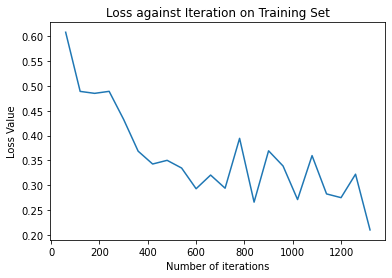

In [195]:
plt.plot(iterations_list, loss_list_training)
plt.xlabel("Number of iterations")
plt.ylabel("Loss Value")
plt.title("Loss against Iteration on Training Set")
plt.show()

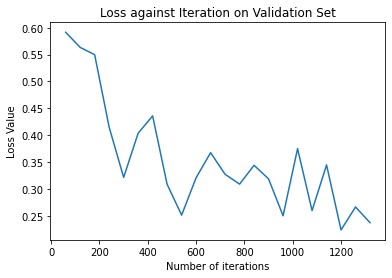

In [196]:
plt.plot(iterations_list, loss_list_testing)
plt.xlabel("Number of iterations")
plt.ylabel("Loss Value")
plt.title("Loss against Iteration on Validation Set")
plt.show()

## Accuracy 

#### Training

In [197]:
with torch.no_grad():
  
  correct_train = 0
  train_samples = 0

  for indx, (inputs, labels) in enumerate(train_loader):

    inputs = inputs.to(device)
    labels = labels.to(device)


    predictions_train = model(inputs)

    # torch.max will return value and index, we are only interested in index, as it will define the predicted label
    _, predict_labels_train = torch.max(predictions_train, 1)

    correct_train += (predict_labels_train == labels).sum().item()
    train_samples += labels.shape[0]

print(f'Train Accuracy: {100*(correct_train/train_samples)}')

Train Accuracy: 90.58148148148149


#### Validation

In [198]:
with torch.no_grad():
  
  correct_val = 0
  val_samples = 0
  k = 1
  for indx, (inputs, labels) in enumerate(val_loader):

    inputs = inputs.to(device)
    labels = labels.to(device)


    predictions_val = model(inputs)
    if k == 1:
      print(f'Predictions val: {predictions_val.size}')
    # torch.max will return value and index, we are only interested in index, as it will define the predicted label
    _, predict_labels_val = torch.max(predictions_val, 1)
    k += 1
    correct_val += (predict_labels_val == labels).sum().item()
    val_samples += labels.shape[0]


Predictions val: <built-in method size of Tensor object at 0x7f0b1ac1d290>


In [199]:
print(f'Validation Accuracy: {100*(correct_val/val_samples)}')

Validation Accuracy: 89.81666666666666


In [200]:
with torch.no_grad():
  
  correct_test = 0
  test_samples = 0
  for indx, (inputs, labels) in enumerate(test_loader):

    inputs = inputs.to(device)
    labels = labels.to(device)


    predictions_test = model(inputs)
    # torch.max will return value and index, we are only interested in index, as it will define the predicted label
    _, predict_labels_test = torch.max(predictions_test, 1)
    correct_test += (predict_labels_test == labels).sum().item()
    test_samples += labels.shape[0]

print(f'Test Accuracy: {100*(correct_test/test_samples)}')

Test Accuracy: 89.07000000000001


## Predictions by Testing Set

In [193]:
predictions_test_ = []
with torch.no_grad():
  
  for indx, (inputs, labels) in enumerate(test_loader):

    inputs = inputs.to(device)
    labels = labels.to(device)


    predictions_test = model(inputs)
    _, predict_labels_test = torch.max(predictions_test, 1)
    predictions_test_.extend(predict_labels_test)